# Set up

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

2024-03-02 11:09:46.340272: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-02 11:09:46.367693: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-02 11:09:46.468020: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-02 11:09:46.468105: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-02 11:09:46.484580: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

# Vanishing/Exploding Gradients Problem

In [2]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

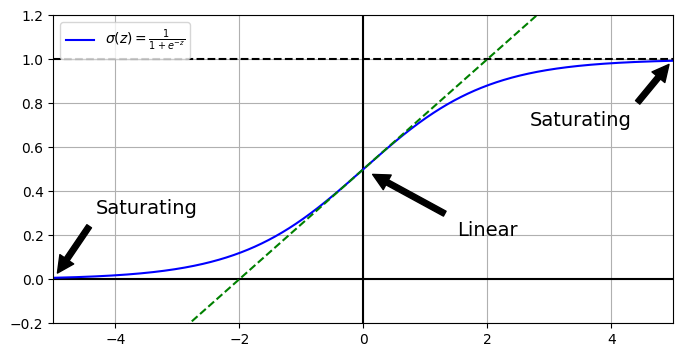

In [3]:
z = np.linspace(-5, 5, 1000)

plt.figure(figsize=(8, 4))
plt.plot([-5, 5], [0, 0], "k-")
plt.plot([-5, 5], [1, 1], "k--")
plt.plot([0, 0], [-0.2, 1.2], "k-")
plt.plot(z, sigmoid(z), "b-", label=r"$\sigma(z) = \frac{1}{1 + e^{-z}}$")
plt.plot([-5, 5], [-3 / 4, 7 / 4], "g--")
props = dict(facecolor="black", shrink=0.1)
plt.annotate(
    "Saturating",
    xytext=(3.5, 0.7),
    xy=(5, 1),
    arrowprops=props,
    fontsize=14,
    ha="center",
)
plt.annotate(
    "Saturating",
    xytext=(-3.5, 0.3),
    xy=(-5, 0),
    arrowprops=props,
    fontsize=14,
    ha="center",
)
plt.annotate(
    "Linear", xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center"
)
plt.grid()
plt.legend(loc="upper left")
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

## Xavier and He initialization                

You can switch to your desired initialization by setting the `kernel_initializer` hyperparameter.

In [4]:
dense = tf.keras.layers.Dense(50, activation="relu", kernel_initializer="he_normal")

If you want to use He initialization with a uniform distribution and based on $fan_{avg}$ instead of $fan_{in}$, you can use the `VarianceScaling` initializer.

In [5]:
he_avg_init = tf.keras.initializers.VarianceScaling(
    scale=2.0, mode="fan_avg", distribution="uniform"
)
dense = tf.keras.layers.Dense(50, activation="sigmoid", kernel_initializer=he_avg_init)

## Non-saturating Activation Functions

### Leaky ReLU

In [6]:
def leaky_relu(z, alpha):
    return np.maximum(z, alpha * z)

(-5.0, 5.0, -1.0, 4.0)

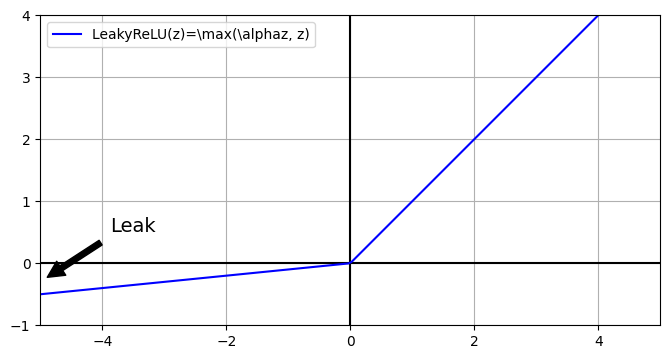

In [7]:
z = np.linspace(-5, 5, 200)
plt.figure(figsize=((8, 5)))
plt.plot([0, 0], [-5, 5], "k-")
plt.plot([-5, 5], [0, 0], "k-")
plt.plot(z, leaky_relu(z, 0.1), "b-", label=r"LeakyReLU(z)=\max(\alphaz, z)")
props = dict(facecolor="black", shrink=0.1)
plt.annotate(
    "Leak",
    xy=(-5, -0.3),
    xytext=(-3.5, 0.5),
    arrowprops=props,
    fontsize=14,
    ha="center",
)
plt.gca().set_aspect("equal")
plt.grid()
plt.legend()
plt.axis([-5, 5, -1, 4])

In [8]:
leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)
dense = tf.keras.layers.Dense(50, activation=leaky_relu, kernel_initializer="he_normal")

In [9]:
model = tf.keras.Sequential(
    [
        # some layers
        tf.keras.layers.Dense(50, kernel_initializer="he_normal"),  # no activation
        tf.keras.layers.LeakyReLU(alpha=0.2),  # activation as a separate layer
        # more layers
    ]
)

### ELU and SELU

- We reimplement the SELU using the coefficient in the paper. <br>
- Note that `erfc(x)` function stands for Complementary Error Function, which is defined as `1-rfc(x)`, where `erf(x)` is the Error Function.<br>
- The formula of `erf()` is:
$$\text{erf}(x) = \frac{2}{\sqrt{\pi}} \int_0^x e^{-t^2}$$
- `erfc(x)` is related to the cumulative distribution function (CDF) of a standard normal distribution:
$$erfc\left(\frac{x}{\sqrt{2}}\right)=2 \times CDF(-x) $$

In [10]:
from scipy.special import erfc

alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e**2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    )
    ** (-1 / 2)
)


def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)


def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

In [11]:
scale_0_1

1.0507009873554805

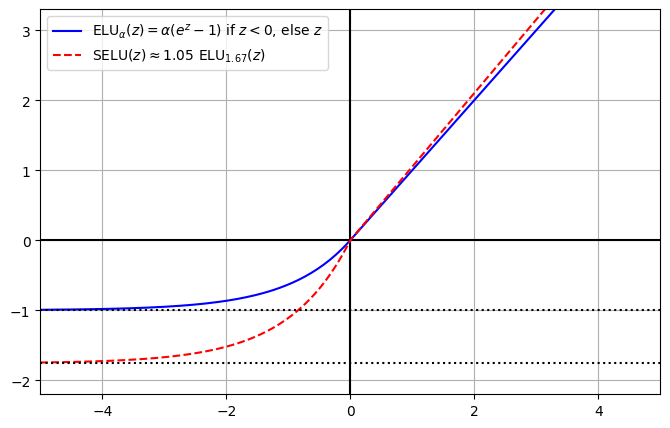

In [12]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(8, 5))
plt.plot([0, 0], [-5, 5], "k-")
plt.plot([-5, 5], [0, 0], "k-")
plt.plot(z, elu(z), "b-", label=r"ELU$_\alpha(z)=\alpha(e^z-1)$ if $z < 0$, else $z$")
plt.plot(z, selu(z), "r--", label=r"SELU$(z)\approx1.05 \ $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [-1, -1], "k:")
plt.plot([-5, 5], [-scale_0_1 * alpha_0_1, -scale_0_1 * alpha_0_1], "k:")
plt.legend()
plt.grid()
plt.axis([-5, 5, -2.2, 3.3])
plt.show()

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer, and use He initialization.

In [13]:
dense = tf.keras.layers.Dense(50, activation="elu", kernel_initializer="he_normal")

Similarly, using SELU is straightforward.

In [14]:
dense = tf.keras.layers.Dense(50, activation="selu", kernel_initializer="lecun_normal")

**Extra material - an example of a self-regularized network using SELU**

Here we create a neural network for Fashion MNIST with 100 hidden layers, using the SELU activation function.

In [15]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(100):
    model.add(
        tf.keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal")
    )
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [16]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    metrics=["accuracy"],
)

Now let's train it. Do not forget to scale the input to mean 0 and standard deviation 1.

In [17]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255.0, X_valid / 255.0, X_test / 255.0

In [18]:
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

In [19]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [20]:
history = model.fit(
    X_train_scaled, y_train, epochs=5, validation_data=(X_valid_scaled, y_valid)
)

Epoch 1/5
1719/1719 [==============================] - 21s 11ms/step - loss: 1.2252 - accuracy: 0.5360 - val_loss: 0.8525 - val_accuracy: 0.7052
Epoch 2/5
1719/1719 [==============================] - 18s 10ms/step - loss: 0.7654 - accuracy: 0.7206 - val_loss: 0.6505 - val_accuracy: 0.7680
Epoch 3/5
1719/1719 [==============================] - 17s 10ms/step - loss: 0.6313 - accuracy: 0.7659 - val_loss: 0.6440 - val_accuracy: 0.7708
Epoch 4/5
1719/1719 [==============================] - 17s 10ms/step - loss: 0.5930 - accuracy: 0.7885 - val_loss: 0.5321 - val_accuracy: 0.8118
Epoch 5/5
1719/1719 [==============================] - 18s 10ms/step - loss: 0.5212 - accuracy: 0.8148 - val_loss: 0.4956 - val_accuracy: 0.8256


The network managed to learn, despite how deep it is. Now look at what happened if we try to use the ReLU activation function instead.

In [21]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(100):
    model.add(
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal")
    )
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [22]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    metrics=["accuracy"],
)

In [23]:
history = model.fit(
    X_train_scaled, y_train, epochs=5, validation_data=(X_valid_scaled, y_valid)
)

Epoch 1/5
1719/1719 [==============================] - 19s 9ms/step - loss: 2.0319 - accuracy: 0.2023 - val_loss: 1.5469 - val_accuracy: 0.3626
Epoch 2/5
1719/1719 [==============================] - 17s 10ms/step - loss: 1.4446 - accuracy: 0.3834 - val_loss: 1.6514 - val_accuracy: 0.3160
Epoch 3/5
1719/1719 [==============================] - 17s 10ms/step - loss: 1.1736 - accuracy: 0.5184 - val_loss: 1.8789 - val_accuracy: 0.2502
Epoch 4/5
1719/1719 [==============================] - 16s 9ms/step - loss: 0.9418 - accuracy: 0.6492 - val_loss: 0.7930 - val_accuracy: 0.7296
Epoch 5/5
1719/1719 [==============================] - 14s 8ms/step - loss: 0.9111 - accuracy: 0.6711 - val_loss: 0.9890 - val_accuracy: 0.6478


Not so great, we suffer from the vanishing/exploding gradients problem.

### GELU, Swish and Mish

In [24]:
def swish(z, beta=1):
    return z * sigmoid(beta * z)


def approx_gelu(z):
    return swish(z, beta=1.702)


def softplus(z):
    return np.log(np.exp(z) + 1)


def mish(z):
    return z * np.tanh(softplus(z))

Text(0.5, 0, 'z')

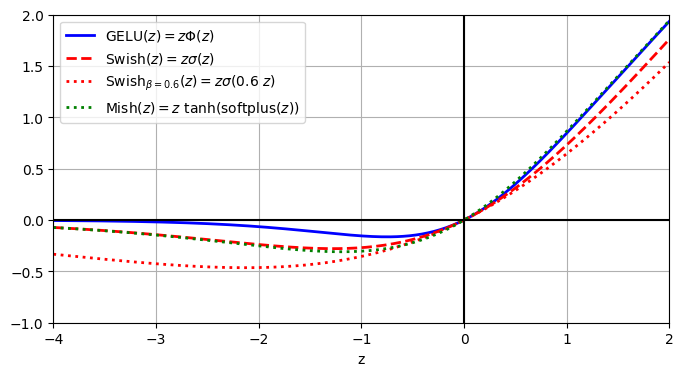

In [25]:
z = np.linspace(-4, 2, 200)

beta = 0.6
plt.figure(figsize=(8, 4))
plt.plot(z, approx_gelu(z), "b-", linewidth=2, label=r"GELU$(z)=z\Phi(z)$")
plt.plot(z, swish(z), "r--", linewidth=2, label=r"Swish$(z)=z\sigma(z)$")
plt.plot(
    z,
    swish(z, 0.6),
    "r:",
    linewidth=2,
    label=rf"Swish$_{{\beta={beta}}}(z)=z\sigma({beta} \ z)$",
)
plt.plot(z, mish(z), "g:", linewidth=2, label=r"Mish$(z)=z \ \tanh($softplus$(z))$")
plt.plot([-5, 5], [0, 0], "k-")
plt.plot([0, 0], [-5, 5], "k-")
plt.legend()
plt.grid()
plt.axis([-4, 2, -1, 2])
plt.gca().set_aspect("equal")
plt.xlabel("z")

# Batch Normalization

In [26]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [27]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)

In this tiny example, just two hidden layers batch normalization is unlikely to make a huge impact, but ofr deeper network it can have a tremendous difference.

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (Batch  (None, 784)               3136      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 batch_normalization_1 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Bat  (None, 100)               4

Let's look at the parameters of the first BN layer:

In [29]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [30]:
# Extra code - just to verify that the model works
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"]
)
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5565 - accuracy: 0.8064 - val_loss: 0.3973 - val_accuracy: 0.8550
Epoch 2/2
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4072 - accuracy: 0.8557 - val_loss: 0.3647 - val_accuracy: 0.8674


In [31]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [32]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation("relu"),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)

In [33]:
# Extra code - just to verify that the model works
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"]
)
model.fit(X_train, y_train, epochs=1, validation_data=(X_valid, y_valid))

1719/1719 [==============================] - 4s 2ms/step - loss: 0.6049 - accuracy: 0.7995 - val_loss: 0.4198 - val_accuracy: 0.8484


## Gradient Clipping

All `tf.keras.optimizers` accept `clipnorm` or `clipvalue` argument.

In [34]:
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

In [35]:
optimizer = tf.keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

## Reusing Pretrained Layers

### Transfer Learning with Keras

In [36]:
sandal_idx = class_names.index("Pullover")
shirt_idx = class_names.index("T-shirt/top")


def split_dataset(X, y):
    # Here, as the model B contains only 2 classes, we assume the positive class is the sandal class and the negative class is the shirt class
    y_for_B = (y == sandal_idx) | (y == shirt_idx)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == sandal_idx).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([sandal_idx, shirt_idx]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # reorder class ids for A
    return (X[~y_for_B], y_A), (X[y_for_B], y_B)


(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [37]:
tf.random.set_seed(42)
model_A = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="softmax"),
    ]
)
model_A.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    metrics=["accuracy"],
)
history = model.fit(
    X_train_A, y_train_A, epochs=20, validation_data=(X_valid_A, y_valid_A)
)
model_A.save("my_model_A")

Epoch 1/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.5922 - val_loss: 0.2952
Epoch 2/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.2966 - val_loss: 0.2556
Epoch 3/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.2629 - val_loss: 0.2439
Epoch 4/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.2379 - val_loss: 0.2361
Epoch 5/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.2225 - val_loss: 0.2269
Epoch 6/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.2118 - val_loss: 0.2218
Epoch 7/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.1983 - val_loss: 0.2196
Epoch 8/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.1895 - val_loss: 0.2212
Epoch 9/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.1820 - val_loss: 0.2104
Epoch 10/20
1376/1376 [==============================] - 3s 2ms/step - loss: 0.173

INFO:tensorflow:Assets written to: my_model_A/assets


In [38]:
tf.random.set_seed(42)
model_B = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model_B.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
    metrics=["accuracy"],
)
history = model_B.fit(
    X_train_B, y_train_B, epochs=20, validation_data=(X_valid_B, y_valid_B)
)
model_B.evaluate(X_test_B, y_test_B)

Epoch 1/20
7/7 [==============================] - 0s 23ms/step - loss: 0.6776 - accuracy: 0.5350 - val_loss: 0.6676 - val_accuracy: 0.5767
Epoch 2/20
7/7 [==============================] - 0s 8ms/step - loss: 0.6469 - accuracy: 0.6550 - val_loss: 0.6412 - val_accuracy: 0.6954
Epoch 3/20
7/7 [==============================] - 0s 8ms/step - loss: 0.6193 - accuracy: 0.7600 - val_loss: 0.6175 - val_accuracy: 0.8022
Epoch 4/20
7/7 [==============================] - 0s 8ms/step - loss: 0.5931 - accuracy: 0.8800 - val_loss: 0.5983 - val_accuracy: 0.8378
Epoch 5/20
7/7 [==============================] - 0s 9ms/step - loss: 0.5726 - accuracy: 0.9000 - val_loss: 0.5789 - val_accuracy: 0.8566
Epoch 6/20
7/7 [==============================] - 0s 7ms/step - loss: 0.5525 - accuracy: 0.9100 - val_loss: 0.5609 - val_accuracy: 0.8704
Epoch 7/20
7/7 [==============================] - 0s 8ms/step - loss: 0.5333 - accuracy: 0.9050 - val_loss: 0.5439 - val_accuracy: 0.8813
Epoch 8/20
7/7 [=================

[0.4100985527038574, 0.9175000190734863]

Model B reached 93.80% accuracy on the test set. Now let's try reusing the pretrained model A.

In [39]:
model_A = tf.keras.models.load_model("my_model_A")
model_B_on_A = tf.keras.Sequential(model_A.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

Note that `model_B_on_A` and `model_A` actually share layers now, so if we train one, it will update both models. If we want to avoid this, we need to build `model_B_on_A` on top of a *clone* of `model_A`.

In [40]:
tf.random.set_seed(42)

model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [41]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(
    loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)

In [42]:
history = model_B_on_A.fit(
    X_train_B, y_train_B, epochs=4, validation_data=(X_valid_B, y_valid_B)
)

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(
    loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)
history = model_B_on_A.fit(
    X_train_B, y_train_B, epochs=16, validation_data=(X_valid_B, y_valid_B)
)

Epoch 1/4


7/7 [==============================] - 0s 22ms/step - loss: 0.6783 - accuracy: 0.5100 - val_loss: 0.6754 - val_accuracy: 0.5153
Epoch 2/4
7/7 [==============================] - 0s 8ms/step - loss: 0.6758 - accuracy: 0.5050 - val_loss: 0.6732 - val_accuracy: 0.5153
Epoch 3/4
7/7 [==============================] - 0s 7ms/step - loss: 0.6732 - accuracy: 0.5050 - val_loss: 0.6708 - val_accuracy: 0.5232
Epoch 4/4
7/7 [==============================] - 0s 8ms/step - loss: 0.6699 - accuracy: 0.5150 - val_loss: 0.6688 - val_accuracy: 0.5272
Epoch 1/16
7/7 [==============================] - 0s 22ms/step - loss: 0.6581 - accuracy: 0.5400 - val_loss: 0.6460 - val_accuracy: 0.5717
Epoch 2/16
7/7 [==============================] - 0s 8ms/step - loss: 0.6344 - accuracy: 0.6300 - val_loss: 0.6268 - val_accuracy: 0.6627
Epoch 3/16
7/7 [==============================] - 0s 8ms/step - loss: 0.6141 - accuracy: 0.7000 - val_loss: 0.6095 - val_accuracy: 0.7616
Epoch 4/16
7/7 [==============================

So what's the final verdict?

In [43]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 707us/step - loss: 0.4604 - accuracy: 0.9140


[0.46035686135292053, 0.9139999747276306]

Well, to our surprise, the model's performance actually drops! The full explanation is in the note.md. 

# Faster Optimizers

In [44]:
# Build some help function to test an optimizer on Fashion MNIST


def build_model(seed: int = 42):
    tf.random.set_seed(42)
    return tf.keras.Sequential(
        [
            tf.keras.layers.Flatten(input_shape=[28, 28]),
            tf.keras.layers.Dense(
                100, activation="relu", kernel_initializer="he_normal"
            ),
            tf.keras.layers.Dense(
                100, activation="relu", kernel_initializer="he_normal"
            ),
            tf.keras.layers.Dense(
                100, activation="relu", kernel_initializer="he_normal"
            ),
            tf.keras.layers.Dense(100, activation="softmax"),
        ]
    )


def build_and_train_model(
    optimizer: tf.keras.optimizers.Optimizer,
) -> tf.keras.callbacks.History:
    model = build_model()
    model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy"],
    )
    return model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

In [45]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [46]:
history_sgd = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.8130 - accuracy: 0.7350 - val_loss: 0.5189 - val_accuracy: 0.8164
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4843 - accuracy: 0.8306 - val_loss: 0.4587 - val_accuracy: 0.8298
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4358 - accuracy: 0.8464 - val_loss: 0.4396 - val_accuracy: 0.8436
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4059 - accuracy: 0.8582 - val_loss: 0.3902 - val_accuracy: 0.8570
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3835 - accuracy: 0.8639 - val_loss: 0.3793 - val_accuracy: 0.8624
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3690 - accuracy: 0.8686 - val_loss: 0.3740 - val_accuracy: 0.8626
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3522 - accuracy: 0.8741 - val_loss: 0.3708 - val_accuracy:

## Momentum optimization

In [47]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [48]:
history_momentum = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.8149 - accuracy: 0.7350 - val_loss: 0.5130 - val_accuracy: 0.8196
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4851 - accuracy: 0.8309 - val_loss: 0.4632 - val_accuracy: 0.8296
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4353 - accuracy: 0.8464 - val_loss: 0.4142 - val_accuracy: 0.8504
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4053 - accuracy: 0.8569 - val_loss: 0.3915 - val_accuracy: 0.8576
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3822 - accuracy: 0.8648 - val_loss: 0.3744 - val_accuracy: 0.8644
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3685 - accuracy: 0.8680 - val_loss: 0.3736 - val_accuracy: 0.8622
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3510 - accuracy: 0.8741 - val_loss: 0.3763 - val_accuracy:

## Nesterov Accelerated Gradient

To use NAG, set the `nesterov` hyperparameter to `True`.

In [49]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

In [50]:
history_nesterov = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.7619 - accuracy: 0.7476 - val_loss: 0.5072 - val_accuracy: 0.8268
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4837 - accuracy: 0.8314 - val_loss: 0.4494 - val_accuracy: 0.8404
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4358 - accuracy: 0.8462 - val_loss: 0.4186 - val_accuracy: 0.8530
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4079 - accuracy: 0.8571 - val_loss: 0.3915 - val_accuracy: 0.8572
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3847 - accuracy: 0.8643 - val_loss: 0.3803 - val_accuracy: 0.8622
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3700 - accuracy: 0.8691 - val_loss: 0.3897 - val_accuracy: 0.8618
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3540 - accuracy: 0.8731 - val_loss: 0.3884 - val_accuracy:

## AdaGrad

**Note**: Even though Keras does have an `Adagrad` optimizer, you should not use it to train deep neural networks (it may be efficient for simpler tasks, such as linear regression, though).

In [52]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)

In [53]:
history_adagrad = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 1.4116 - accuracy: 0.5958 - val_loss: 0.8131 - val_accuracy: 0.7470
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.7435 - accuracy: 0.7512 - val_loss: 0.6715 - val_accuracy: 0.7746
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6499 - accuracy: 0.7833 - val_loss: 0.6073 - val_accuracy: 0.8008
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6007 - accuracy: 0.8004 - val_loss: 0.5723 - val_accuracy: 0.8108
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5690 - accuracy: 0.8098 - val_loss: 0.5465 - val_accuracy: 0.8148
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5462 - accuracy: 0.8162 - val_loss: 0.5299 - val_accuracy: 0.8172
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5292 - accuracy: 0.8211 - val_loss: 0.5135 - val_accuracy:

## RMSProp

In [54]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

In [55]:
history_rmsprop = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5373 - accuracy: 0.8089 - val_loss: 0.4335 - val_accuracy: 0.8322
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3895 - accuracy: 0.8590 - val_loss: 0.4386 - val_accuracy: 0.8416
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3630 - accuracy: 0.8696 - val_loss: 0.3868 - val_accuracy: 0.8648
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3534 - accuracy: 0.8754 - val_loss: 0.3623 - val_accuracy: 0.8738
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3483 - accuracy: 0.8781 - val_loss: 0.3767 - val_accuracy: 0.8726
Epoch 6/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.3456 - accuracy: 0.8799 - val_loss: 0.4293 - val_accuracy: 0.8632
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3451 - accuracy: 0.8801 - val_loss: 0.4074 - val_accuracy:

## Adam

In [56]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [57]:
history_adam = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5328 - accuracy: 0.8129 - val_loss: 0.4374 - val_accuracy: 0.8336
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3775 - accuracy: 0.8612 - val_loss: 0.4015 - val_accuracy: 0.8472
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3395 - accuracy: 0.8746 - val_loss: 0.3585 - val_accuracy: 0.8702
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3173 - accuracy: 0.8824 - val_loss: 0.3479 - val_accuracy: 0.8704
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2959 - accuracy: 0.8904 - val_loss: 0.3326 - val_accuracy: 0.8746
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2814 - accuracy: 0.8957 - val_loss: 0.3296 - val_accuracy: 0.8822
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2694 - accuracy: 0.8990 - val_loss: 0.3549 - val_accuracy:

### AdaMax optimization

In [58]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [59]:
history_adamax = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5831 - accuracy: 0.8011 - val_loss: 0.4755 - val_accuracy: 0.8226
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4093 - accuracy: 0.8537 - val_loss: 0.3913 - val_accuracy: 0.8572
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3693 - accuracy: 0.8674 - val_loss: 0.3729 - val_accuracy: 0.8648
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3413 - accuracy: 0.8778 - val_loss: 0.3427 - val_accuracy: 0.8740
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3211 - accuracy: 0.8839 - val_loss: 0.3332 - val_accuracy: 0.8762
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3068 - accuracy: 0.8877 - val_loss: 0.3416 - val_accuracy: 0.8724
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2928 - accuracy: 0.8920 - val_loss: 0.3373 - val_accuracy:

### Nadam optimization

In [60]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [61]:
history_nadam = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 5s 2ms/step - loss: 0.5151 - accuracy: 0.8212 - val_loss: 0.4158 - val_accuracy: 0.8430
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3687 - accuracy: 0.8658 - val_loss: 0.3738 - val_accuracy: 0.8580
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3338 - accuracy: 0.8778 - val_loss: 0.3419 - val_accuracy: 0.8776
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3113 - accuracy: 0.8860 - val_loss: 0.3393 - val_accuracy: 0.8754
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2944 - accuracy: 0.8913 - val_loss: 0.3292 - val_accuracy: 0.8772
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2811 - accuracy: 0.8952 - val_loss: 0.3478 - val_accuracy: 0.8782
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2703 - accuracy: 0.8987 - val_loss: 0.3474 - val_accuracy:

### AdamW optimization

**Note**: Since TF 1.12, `AdamW` is no longer experimental. It is available at `tf.keras.optimizers.AdamW`, instead of `tf.keras.optimizers.experimental.AdamW`.

In [62]:
optimizer = tf.keras.optimizers.AdamW(
    weight_decay=1e-5, learning_rate=0.001, beta_1=0.9, beta_2=0.999
)

In [63]:
history_adamw = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5306 - accuracy: 0.8133 - val_loss: 0.4241 - val_accuracy: 0.8360
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3781 - accuracy: 0.8609 - val_loss: 0.3951 - val_accuracy: 0.8476
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3439 - accuracy: 0.8728 - val_loss: 0.3451 - val_accuracy: 0.8746
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3198 - accuracy: 0.8813 - val_loss: 0.3488 - val_accuracy: 0.8722
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3016 - accuracy: 0.8882 - val_loss: 0.3221 - val_accuracy: 0.8786
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2881 - accuracy: 0.8927 - val_loss: 0.3447 - val_accuracy: 0.8756
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.2739 - accuracy: 0.8971 - val_loss: 0.3412 - val_accuracy:

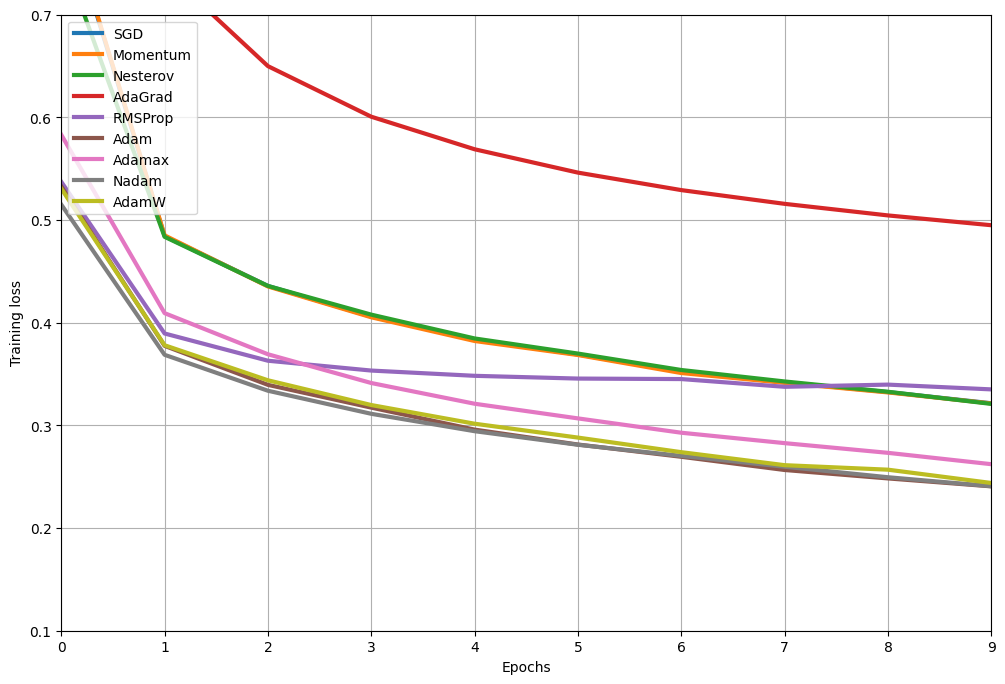

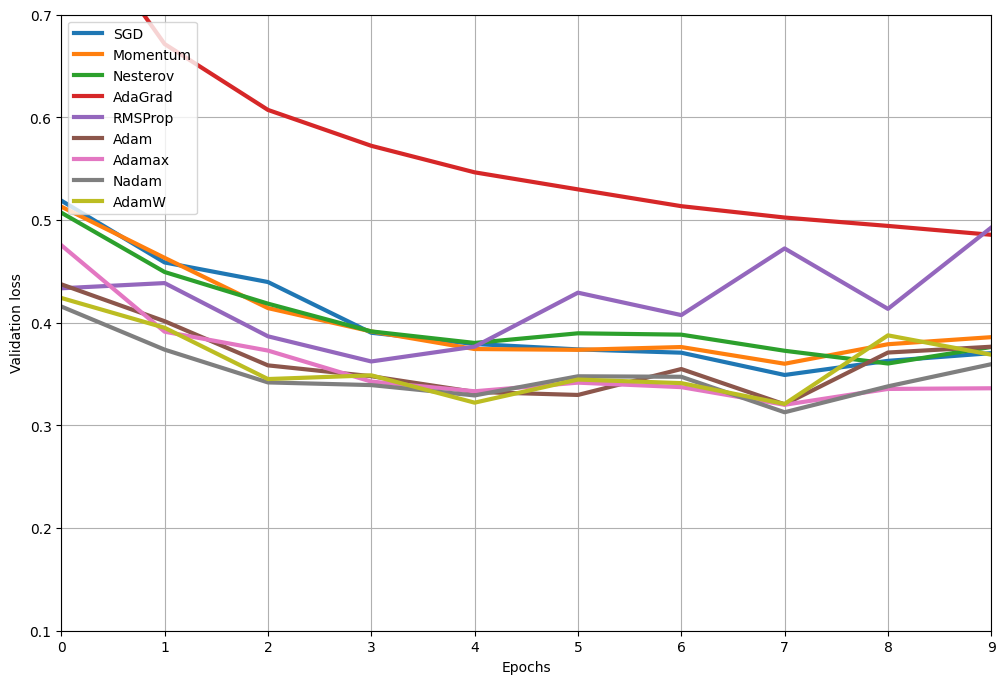

In [65]:
# Extra code to visualize the learning curves of all the optimizers

for loss in ("loss", "val_loss"):
    plt.figure(figsize=(12, 8))
    optimizers_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, optimizer_name in zip(
        (
            history_sgd,
            history_momentum,
            history_nesterov,
            history_adagrad,
            history_rmsprop,
            history_adam,
            history_adamax,
            history_nadam,
            history_adamw,
        ),
        optimizers_names.split(),
    ):
        plt.plot(history.history[loss], label=f"{optimizer_name}", linewidth=3)

    plt.grid()
    plt.xlabel("Epochs")
    if loss == "loss":
        plt.ylabel("Training loss")
    if loss == "val_loss":
        plt.ylabel("Validation loss")
    plt.legend(loc="upper left")
    plt.axis([0, 9, 0.1, 0.7])
    plt.show()